# Instacart Basket Analysis

1. Used Data (Base Line):
    1. [https://github.com/KazukiOnodera/Instacart](https://github.com/KazukiOnodera/Instacart) 
    2. [https://www.kaggle.com/charalambos/xgb-of-instacart-ml-2-notebook](https://www.kaggle.com/charalambos/xgb-of-instacart-ml-2-notebook) → Baseline 모델로 이용
    3. [https://www.kaggle.com/sudalairajkumar/simple-exploration-notebook-instacart/notebook](https://www.kaggle.com/sudalairajkumar/simple-exploration-notebook-instacart/notebook()) → Visaulization 및 EDA 참고
2. Problem : 
Predict which previously purchased products will be in a user’s next order.<br>
    1. 특정 고객이 가진 주문정보 만으로는 그 수가 적어 제대로 된 예측을 할 수 없다. ( 약 15개의 주문정보 뿐) 전체 고객의 확률분포를 가지고 특정 고객의 확률분포를 이용하는 것은 문제가 많아(고객의 특성을 반영하지 못함). 이를 해결하고자, 표본집단이 얼마나 모집단을 잘 대표하는지 대표성을 구하고자 하였습니다. 따라서, 어떤 고객의 특성을 잘 대변하는 집단으로 묶어서 그 집단의 확률을 구한다면 좀 더 잘 대표하지 않을까 생각하였습니다.
    2. 결국 특정 손님이 이 물건을 미래 구매 여부를 예측하는 문제다. 이를 추론하기 위해선 이 손님이 정보를 알고 있는 손님과 얼마나 유사하게 제품을 구매 하는 지를 이용하여 → 특정 집단에 속하는 고객이라면 다음 물품은 어떤 것을 구매할 확률이 높다고 가설을 세웠습니다.
    
3. Feature selection : 
| 0     | category       | variable                              | Formula&Feature                                                                                                                                                                        |
|-------|----------------|---------------------------------------|----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| 1     | user           | Times_Bought_N                        | dataset.groupby(['user_id', 'product_id'])[['order_id']].count()<br/>유저가 산 특정 상품의 총 주문 횟수                                                                                              |
| 2     | user           | total_orders                          | dataset.groupby('user_id')['order_number'].max()<br/>유저별 총 주문 횟수                                                                                                                       |
| 3     | user x product | uxp_reorder_ratio                     | dataset.Times_Bought_N / dataset.total_orders-dataset.first_order_number+1<br/>유저가 첫주문 이후 특정 상품을 재주문 할 확률                                                                              |
| 4     | user           | u_reordered                           | dataset.groupby(['user_id'])['reordered'].aggregate('mean')<br/>유저가 재주문할 확률                                                                                                            |
| 5     | product        | product_total_purchases               | dataset.groupby('product_id')['order_id'].count()<br/>상품이 총 팔린 횟수                                                                                                                      |
| 6     | product        | p_reorder_ratio                       | dataset.groupby('product_id')['reordered'].mean()<br/>상품별 재주문될 평균 확률                                                                                                                   |
| 7     | -              | eval_set                              | 평가 set                                                                                                                                                                                 |
| 8     | -              | order_id                              | 주문 id                                                                                                                                                                                  |
| 9     | time           | order_hour_of_day                     | 상품 구매한 시각                                                                                                                                                                              |
| 10    | time           | order_dow                             | 상품을 주문한 요일 (기본 데이터셋)                                                                                                                                                                   |
| 11    | product        | aisle_id                              | aisle id                                                                                                                                                                               |
| 12    | product        | department_id                         | department_id                                                                                                                                                                          |
| 13    | product        | mean_position                         | dataset.groupby('product_id')['add_to_cart_order'].mean().reset_index(name = 'mean_position')<br/>상품이 카트에 추가 되는 순서 평균                                                                  |
| 14    | product        | dept_rodrder_rate                     | dataset.groupby('department')['reordered'].mean()<br/>품목별 재주문 확률                                                                                                                       |
| 15    | product        | aisle_reorder_reate                   | dataset.groupby('aisle')['reordered'].mean() <br/>aisle재주문 확률                                                                                                                          |
| 16    | product        | dow_reordered                         | dataset.groupby('order_dow')['reordered'].mean() <br/>요일 별 재주문 확률                                                                                                                      |
| 17    | product        | dow_aisle_reordered                   | dataset.groupby(['order_dow', 'aisle_id'])['reordered'].mean()<br/>요일에 따른 ailsle 재주문 확률                                                                                                |
| 18    | product        | dow_dept_reordered                    | dataset.groupby(['departmet_id', 'aisle_id'])['reordered'].mean() <br/>요일에 따른 품목 재주문 확률                                                                                                |
| 19    | product        | dept_percentage                       | dataset['department_id'].value_counts().to_frame('dept_percentage').reset_index()<br/>dept_percentage['dept_percentage']/sum(dept_percentage['dept_percentage'])<br/>품목별 주문확률          |
| 20    | time           | dow_hour_rorder                       | dataset.groupby(['order_dow', 'order_hour_of_day'])['reordered'].mean()<br/>요일과 시간에 따른 재주문 확률                                                                                          |
| 21    | prodct         | product_roredered_dow                 | dataset.groupby(['product_id','order_dow'])["reordered"].mean()<br/>요일별 특정 상품의 재주문 확률                                                                                                  |
| 22    | product        | prod_rordered_hod                     | dataset.groupby(['product_id','order_hour_of_day'])["reordered"].mean()<br/> 시간별 특정 상품의 재주문 확률                                                                                         |
| 23    | time           | day_reorder_rate                      | df = prior_data.groupby(['product_id','order_dow'])["product_id"].size()<br/>df = df/prior_data.groupby(["product_id"]).size() #특정 상품의 총 주문량<br/>요일별 특정 상품 주문량/ 특정 상품 총 주문량            |
| 24    | time           | hour_reorder_rate                     |  df = prior_data.groupby(['product_id','order_hour_of_day'])["reordered"].size()<br/> df = df/prior_data.groupby(["product_id"]).size()<br/>시간별 특정 상품 주문량/특정 상품 총 주문량                  |
| 25    | time           | p_days_since_prior_order_reorder_rate | df = prior_data.groupby(['product_id','days_since_prior_order'])["reordered"].size()<br/>df = df/prior_data.groupby(["product_id"]).size()<br/>상품별 다음 재주문시 걸리는 날짜의 확률                  |
| 26    | time           | days_since_prior_order                | 주문 이후 재주문 하는 일수                                                                                                                                                                        |
| 27    | time           | days_since_prior_reorder_rate         | df = prior_data.groupby(["user_id","product_id","days_since_prior_order"])["reordered"].size()<br/>df = df/prior_data.groupby(["user_id","product_id"]).size()<br/>특정 상품을 주문후 재주문하는 확률 |
| 28    | product        | uxp_mean_position                     | dataset.groupby(["user_id","product_id"])['add_to_cart_order'].mean()<br/>고객이 카트에 추가하는 상품의 평균 순서                                                                                       |
| 29~31 | product        | p_reduced_feat_1~3                    | product_name 에서 높은 빈도를 나타낸 단어로 8개의 그룹을 만든후 NMF로 차원 축소를 하여 변수 3개 생성<br/>많은 구매를한 상품군                                                                                                     |
| 32    | y              | reordered                             | 재구매                                                                                                                                                                                    |
    
    
4. Model : XGBoost, Catboost, Logistic Regression, Random Forest
5. Score  <br>
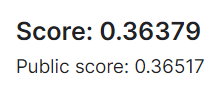

In [1]:
#Importing useful libraries
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import sys
import os
color = sns.color_palette()
%matplotlib inline
# Garbage Collector to free up memory
import gc                         
gc.enable()

## Insta Cart Toy Project
- EDA
- Visulaization
- Analysis
- Train & Vailate
- Result

In [3]:
# Data load
aisles = pd.read_csv('/home/jovyan/nas/1_user/hjlee@agilesoda.ai/Instacart/data_set/aisles.csv')
departments = pd.read_csv('/home/jovyan/nas/1_user/hjlee@agilesoda.ai/Instacart/data_set/departments.csv')
order_prod_prior = pd.read_csv('/home/jovyan/nas/1_user/hjlee@agilesoda.ai/Instacart/data_set/order_products__prior.csv')

order_prod_train = pd.read_csv('/home/jovyan/nas/1_user/hjlee@agilesoda.ai/Instacart/data_set/order_products__train.csv')
orders = pd.read_csv('/home/jovyan/nas/1_user/hjlee@agilesoda.ai/Instacart/data_set/orders.csv')
products = pd.read_csv('/home/jovyan/nas/1_user/hjlee@agilesoda.ai/Instacart/data_set/products.csv')

## 1. EDA

In [443]:
# aisles.describe()
# order_prod_prior.describe()
orders.describe()

,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order
count,3.421083e+06,3.421083e+06,3.421083e+06,3.421083e+06,3.421083e+06,3.214874e+06
mean,1.710542e+06,1.029782e+05,1.715486e+01,2.776219e+00,1.345202e+01,1.111484e+01
std,9.875817e+05,5.953372e+04,1.773316e+01,2.046829e+00,4.226088e+00,9.206737e+00
min,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,8.552715e+05,5.139400e+04,5.000000e+00,1.000000e+00,1.000000e+01,4.000000e+00
50%,1.710542e+06,1.026890e+05,1.100000e+01,3.000000e+00,1.300000e+01,7.000000e+00
75%,2.565812e+06,1.543850e+05,2.300000e+01,5.000000e+00,1.600000e+01,1.500000e+01
max,3.421083e+06,2.062090e+05,1.000000e+02,6.000000e+00,2.300000e+01,3.000000e+01


In [158]:
display(orders)
display(orders[(orders['user_id'] == 1)].head())
display(orders[(orders['order_id']==2539329)].head())

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0
...,...,...,...,...,...,...,...
3421078,2266710,206209,prior,10,5,18,29.0
3421079,1854736,206209,prior,11,4,10,30.0
3421080,626363,206209,prior,12,1,12,18.0
3421081,2977660,206209,prior,13,1,12,7.0


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN


In [7]:
# make main dataset
all_join = pd.merge(left = order_prod_prior, right = orders , how = 'left', on ='order_id')
all_join = pd.merge(left = all_join, right = products , how = 'left', on ='product_id')
all_join = pd.merge(left = all_join, right = aisles , how = 'left', on ='aisle_id')
all_join = pd.merge(left = all_join, right = departments , how = 'left', on ='department_id')
display(all_join)
display(order_prod_prior)

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_name,aisle_id,department_id,aisle,department
0,2,33120,1,1,202279,prior,3,5,9,8.0,Organic Egg Whites,86,16,eggs,dairy eggs
1,2,28985,2,1,202279,prior,3,5,9,8.0,Michigan Organic Kale,83,4,fresh vegetables,produce
2,2,9327,3,0,202279,prior,3,5,9,8.0,Garlic Powder,104,13,spices seasonings,pantry
3,2,45918,4,1,202279,prior,3,5,9,8.0,Coconut Butter,19,13,oils vinegars,pantry
4,2,30035,5,0,202279,prior,3,5,9,8.0,Natural Sweetener,17,13,baking ingredients,pantry
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32434484,3421083,39678,6,1,25247,prior,24,2,6,21.0,Free & Clear Natural Dishwasher Detergent,74,17,dish detergents,household
32434485,3421083,11352,7,0,25247,prior,24,2,6,21.0,Organic Mini Sandwich Crackers Peanut Butter,78,19,crackers,snacks
32434486,3421083,4600,8,0,25247,prior,24,2,6,21.0,All Natural French Toast Sticks,52,1,frozen breakfast,frozen
32434487,3421083,24852,9,1,25247,prior,24,2,6,21.0,Banana,24,4,fresh fruits,produce


,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0
...,...,...,...,...
32434484,3421083,39678,6,1
32434485,3421083,11352,7,0
32434486,3421083,4600,8,0
32434487,3421083,24852,9,1


## User Frequency
1. Hard coding
2. Clean code

In [8]:
# frequency of reorder for each user ex). user_id = 1
# all_join[(all_join['product_id']==196)&(all_join['user_id']==1)].count()
user1_reorder = all_join[(all_join['reordered'] == 1) & (all_join['user_id'] == 1)].user_id.count()
user1_total_order = all_join[(all_join['user_id'] == 1)].user_id.count()
user1_reorder_frequency = user1_reorder / user1_total_order
print(user1_reorder_frequency)

0.6949152542372882


In [13]:
# 2. Clean code
grouped_frequency = all_join.groupby(['user_id'])['reordered'].mean().to_frame('u_reordered')
grouped_frequency

,u_reordered
user_id,
1,0.694915
2,0.476923
3,0.625000
4,0.055556
5,0.378378
...,...
206205,0.250000
206206,0.473684
206207,0.587444


In [159]:
user = grouped_frequency

In [15]:
# Most purchased products
# Products purchased
products_purchased = all_join.groupby('product_id')['order_id'].count().to_frame('product_total_purchases')
products_purchased

,product_total_purchases
product_id,
1,1852
2,90
3,277
4,329
5,15
...,...
49684,9
49685,49
49686,120


In [16]:
# For individual marketing which product did user buy
times = all_join.groupby(['user_id', 'product_id'])[['order_id']].count()
times.columns = ['Times_Bought_N']
times.head()

Times_Bought_N
user_id product_id                
1       196                     10
        10258                    9
        10326                    1
        12427                   10
        13032                    3

In [17]:
# user's total orders: order_number's max
total_orders = all_join.groupby('user_id')['order_number'].max().to_frame('total_orders')
total_orders

,total_orders
user_id,
1,10
2,14
3,12
4,5
5,4
...,...
206205,3
206206,67
206207,16


In [18]:
# To find when users ordered their products at the first time (at this point because of goupby func row 3million ->1.3million)
first_order_no = all_join.groupby(['user_id', 'product_id'])['order_number'].min().to_frame('first_order_number')
first_order_no  = first_order_no.reset_index()
first_order_no

,user_id,product_id,first_order_number
0,1,196,1
1,1,10258,2
2,1,10326,5
3,1,12427,1
4,1,13032,2
...,...,...,...
13307948,206209,43961,4
13307949,206209,44325,7
13307950,206209,48370,11
13307951,206209,48697,7


In [19]:
# mean ratio of the _total
p_reorder = all_join.groupby('product_id')['reordered'].mean().to_frame('p_reorder_ratio')
p_reorder

,p_reorder_ratio
product_id,
1,0.613391
2,0.133333
3,0.732852
4,0.446809
5,0.600000
...,...
49684,0.111111
49685,0.122449
49686,0.700000


In [20]:
span = pd.merge(total_orders, first_order_no, on='user_id', how='right')
span

,user_id,total_orders,product_id,first_order_number
0,1,10,196,1
1,1,10,10258,2
2,1,10,10326,5
3,1,10,12427,1
4,1,10,13032,2
...,...,...,...,...
13307948,206209,13,43961,4
13307949,206209,13,44325,7
13307950,206209,13,48370,11
13307951,206209,13,48697,7


In [21]:
span['Order_Range_D'] = span.total_orders - span.first_order_number + 1
span

,user_id,total_orders,product_id,first_order_number,Order_Range_D
0,1,10,196,1,10
1,1,10,10258,2,9
2,1,10,10326,5,6
3,1,10,12427,1,10
4,1,10,13032,2,9
...,...,...,...,...,...
13307948,206209,13,43961,4,10
13307949,206209,13,44325,7,7
13307950,206209,13,48370,11,3
13307951,206209,13,48697,7,7


In [22]:
uxp_ratio = pd.merge(times, span, on = ['user_id', 'product_id'], how='left')
uxp_ratio

,user_id,product_id,Times_Bought_N,total_orders,first_order_number,Order_Range_D
0,1,196,10,10,1,10
1,1,10258,9,10,2,9
2,1,10326,1,10,5,6
3,1,12427,10,10,1,10
4,1,13032,3,10,2,9
...,...,...,...,...,...,...
13307948,206209,43961,3,13,4,10
13307949,206209,44325,1,13,7,7
13307950,206209,48370,1,13,11,3
13307951,206209,48697,1,13,7,7


In [23]:
uxp_ratio['uxp_reorder_ratio'] = uxp_ratio.Times_Bought_N / uxp_ratio.Order_Range_D
uxp_ratio

,user_id,product_id,Times_Bought_N,total_orders,first_order_number,Order_Range_D,uxp_reorder_ratio
0,1,196,10,10,1,10,1.000000
1,1,10258,9,10,2,9,1.000000
2,1,10326,1,10,5,6,0.166667
3,1,12427,10,10,1,10,1.000000
4,1,13032,3,10,2,9,0.333333
...,...,...,...,...,...,...,...
13307948,206209,43961,3,13,4,10,0.300000
13307949,206209,44325,1,13,7,7,0.142857
13307950,206209,48370,1,13,11,3,0.333333
13307951,206209,48697,1,13,7,7,0.142857


In [24]:
uxp_ratio = uxp_ratio.drop(['first_order_number', 'Order_Range_D'], axis = 1)
uxp_ratio

,user_id,product_id,Times_Bought_N,total_orders,uxp_reorder_ratio
0,1,196,10,10,1.000000
1,1,10258,9,10,1.000000
2,1,10326,1,10,0.166667
3,1,12427,10,10,1.000000
4,1,13032,3,10,0.333333
...,...,...,...,...,...
13307948,206209,43961,3,13,0.300000
13307949,206209,44325,1,13,0.142857
13307950,206209,48370,1,13,0.333333
13307951,206209,48697,1,13,0.142857


In [25]:
# del [times, first_order_no, span]

In [26]:
data = uxp_ratio.merge(user, on = 'user_id', how = 'left')
data

,user_id,product_id,Times_Bought_N,total_orders,uxp_reorder_ratio,u_reordered
0,1,196,10,10,1.000000,0.694915
1,1,10258,9,10,1.000000,0.694915
2,1,10326,1,10,0.166667,0.694915
3,1,12427,10,10,1.000000,0.694915
4,1,13032,3,10,0.333333,0.694915
...,...,...,...,...,...,...
13307948,206209,43961,3,13,0.300000,0.472868
13307949,206209,44325,1,13,0.142857,0.472868
13307950,206209,48370,1,13,0.333333,0.472868
13307951,206209,48697,1,13,0.142857,0.472868


In [27]:
data = data.merge(products_purchased, on = 'product_id', how = 'left')
data

,user_id,product_id,Times_Bought_N,total_orders,uxp_reorder_ratio,u_reordered,product_total_purchases
0,1,196,10,10,1.000000,0.694915,35791
1,1,10258,9,10,1.000000,0.694915,1946
2,1,10326,1,10,0.166667,0.694915,5526
3,1,12427,10,10,1.000000,0.694915,6476
4,1,13032,3,10,0.333333,0.694915,3751
...,...,...,...,...,...,...,...
13307948,206209,43961,3,13,0.300000,0.472868,55371
13307949,206209,44325,1,13,0.142857,0.472868,3485
13307950,206209,48370,1,13,0.333333,0.472868,3934
13307951,206209,48697,1,13,0.142857,0.472868,9783


In [28]:
data['product_total_purchases'] = data['product_total_purchases'].fillna(value = 0)

In [29]:
data = data.merge(p_reorder, on = 'product_id', how = 'left')
data

,user_id,product_id,Times_Bought_N,total_orders,uxp_reorder_ratio,u_reordered,product_total_purchases,p_reorder_ratio
0,1,196,10,10,1.000000,0.694915,35791,0.776480
1,1,10258,9,10,1.000000,0.694915,1946,0.713772
2,1,10326,1,10,0.166667,0.694915,5526,0.652009
3,1,12427,10,10,1.000000,0.694915,6476,0.740735
4,1,13032,3,10,0.333333,0.694915,3751,0.657158
...,...,...,...,...,...,...,...,...
13307948,206209,43961,3,13,0.300000,0.472868,55371,0.630583
13307949,206209,44325,1,13,0.142857,0.472868,3485,0.401148
13307950,206209,48370,1,13,0.333333,0.472868,3934,0.699288
13307951,206209,48697,1,13,0.142857,0.472868,9783,0.357661


In [30]:
orders_future = orders[((orders.eval_set == 'train') | (orders.eval_set == 'test'))]
orders_future = orders_future[ ['user_id', 'eval_set', 'order_id'] ]

In [31]:
orders_future

,user_id,eval_set,order_id
10,1,train,1187899
25,2,train,1492625
38,3,test,2774568
44,4,test,329954
49,5,train,2196797
...,...,...,...
3420933,206205,train,1716008
3421001,206206,test,1043943
3421018,206207,test,2821651
3421068,206208,test,803273


## Add mor features
### Features
1. How many times did user bought
2. Ratio of user bought the product
3. Ratio of user's reorder percentage
4. Product information of total purchased
5. product's reordered ration


In [32]:
# bring the info of the future orders to data DF
data_1 = data.merge(orders_future, on = 'user_id', how = 'left')
data_1

,user_id,product_id,Times_Bought_N,total_orders,uxp_reorder_ratio,u_reordered,product_total_purchases,p_reorder_ratio,eval_set,order_id
0,1,196,10,10,1.000000,0.694915,35791,0.776480,train,1187899
1,1,10258,9,10,1.000000,0.694915,1946,0.713772,train,1187899
2,1,10326,1,10,0.166667,0.694915,5526,0.652009,train,1187899
3,1,12427,10,10,1.000000,0.694915,6476,0.740735,train,1187899
4,1,13032,3,10,0.333333,0.694915,3751,0.657158,train,1187899
...,...,...,...,...,...,...,...,...,...,...
13307948,206209,43961,3,13,0.300000,0.472868,55371,0.630583,train,272231
13307949,206209,44325,1,13,0.142857,0.472868,3485,0.401148,train,272231
13307950,206209,48370,1,13,0.333333,0.472868,3934,0.699288,train,272231
13307951,206209,48697,1,13,0.142857,0.472868,9783,0.357661,train,272231


In [33]:
#, 'department_id', 'aisle_id' 여기서 3000만으로 증가
new_d_set = all_join[['user_id','product_id','order_hour_of_day', 'order_dow', 'days_since_prior_order', 'department_id', 'aisle_id']]
data_1 = data_1.merge(new_d_set, on = ['user_id','product_id'], how = 'left')
data_1

,user_id,product_id,Times_Bought_N,total_orders,uxp_reorder_ratio,u_reordered,product_total_purchases,p_reorder_ratio,eval_set,order_id,order_hour_of_day,order_dow,days_since_prior_order,department_id,aisle_id
0,1,196,10,10,1.000000,0.694915,35791,0.776480,train,1187899,15,4,28.0,7,77
1,1,196,10,10,1.000000,0.694915,35791,0.776480,train,1187899,12,3,21.0,7,77
2,1,196,10,10,1.000000,0.694915,35791,0.776480,train,1187899,9,1,20.0,7,77
3,1,196,10,10,1.000000,0.694915,35791,0.776480,train,1187899,7,4,29.0,7,77
4,1,196,10,10,1.000000,0.694915,35791,0.776480,train,1187899,16,1,0.0,7,77
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32434484,206209,44325,1,13,0.142857,0.472868,3485,0.401148,train,272231,13,2,9.0,9,131
32434485,206209,48370,1,13,0.333333,0.472868,3934,0.699288,train,272231,10,4,30.0,17,54
32434486,206209,48697,1,13,0.142857,0.472868,9783,0.357661,train,272231,13,2,9.0,13,19
32434487,206209,48742,2,13,0.285714,0.472868,1723,0.498549,train,272231,13,2,9.0,14,130


In [34]:
# 상품이 카트에 추가 되는 순서 평균
mean_position = all_join.groupby('product_id')['add_to_cart_order'].mean().reset_index(name = 'mean_position')
#Get aisle reorder rate
aisle_reorder_rate = all_join.groupby(['aisle_id'])['reordered'].mean().reset_index(name = 'aisle_reorder_rate') 
#Get dept reorder rate
dept_reorder_rate = all_join.groupby(['department_id'])['reordered'].mean().reset_index(name = 'dept_reorder_rate')

In [35]:
# data_1 = data_1.merge(products, on=['product_id'], how='left')
data_1 = data_1.merge(mean_position, on = ['product_id'], how = 'left')
data_1 = data_1.merge(dept_reorder_rate, on = ['department_id'], how = 'left')
data_1 = data_1.merge(aisle_reorder_rate, on = ['aisle_id'], how = 'left')

In [36]:
data_1

,user_id,product_id,Times_Bought_N,total_orders,uxp_reorder_ratio,u_reordered,product_total_purchases,p_reorder_ratio,eval_set,order_id,order_hour_of_day,order_dow,days_since_prior_order,department_id,aisle_id,mean_position,dept_reorder_rate,aisle_reorder_rate
0,1,196,10,10,1.000000,0.694915,35791,0.776480,train,1187899,15,4,28.0,7,77,3.721774,0.653460,0.638832
1,1,196,10,10,1.000000,0.694915,35791,0.776480,train,1187899,12,3,21.0,7,77,3.721774,0.653460,0.638832
2,1,196,10,10,1.000000,0.694915,35791,0.776480,train,1187899,9,1,20.0,7,77,3.721774,0.653460,0.638832
3,1,196,10,10,1.000000,0.694915,35791,0.776480,train,1187899,7,4,29.0,7,77,3.721774,0.653460,0.638832
4,1,196,10,10,1.000000,0.694915,35791,0.776480,train,1187899,16,1,0.0,7,77,3.721774,0.653460,0.638832
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32434484,206209,44325,1,13,0.142857,0.472868,3485,0.401148,train,272231,13,2,9.0,9,131,10.109900,0.461076,0.453062
32434485,206209,48370,1,13,0.333333,0.472868,3934,0.699288,train,272231,10,4,30.0,17,54,8.344942,0.402178,0.528005
32434486,206209,48697,1,13,0.142857,0.472868,9783,0.357661,train,272231,13,2,9.0,13,19,8.763058,0.346721,0.350843
32434487,206209,48742,2,13,0.285714,0.472868,1723,0.498549,train,272231,13,2,9.0,14,130,7.991294,0.560922,0.499501


In [37]:
# 유저가 어떤 요일 어떤 물건을 살 확률 
dow_reordered = all_join.groupby(['order_dow'])['reordered'].mean().to_frame('dow_rordered')
# 요일별 aisle에서 재 판매되는 확률
dow_aisle_reordered = all_join.groupby(['order_dow', 'aisle_id'])['reordered'].mean().to_frame('dow_aisle_rordered').reset_index()
# 요일별 dept에서 재 판매되는 확률
dow_dept_reordered = all_join.groupby(['order_dow', 'department_id'])['reordered'].mean().to_frame('dow_dept_rordered').reset_index()

In [38]:
# dept별 분포 
dept_percentage = all_join['department_id'].value_counts().to_frame('dept_percentage').reset_index()
dept_percentage['dept_percentage']= dept_percentage['dept_percentage']/sum(dept_percentage['dept_percentage'])
dept_percentage = dept_percentage.rename(columns = {'index': 'department_id'})
# 요일별 재 구매 시간 평균
dow_hour_reorder = all_join.groupby(['order_dow', 'order_hour_of_day'])['reordered'].aggregate('mean').to_frame('dow_hour_reorder').reset_index()

In [39]:
# 각 상품의 요일별 재구매 확귤 
prod_reordered_dow = all_join.groupby(['product_id','order_dow'])["reordered"].mean().to_frame('product_reordered_dow')
# 각 상품의 시간별 재구매 확률
prod_reordered_hod = all_join.groupby(['product_id','order_hour_of_day'])["reordered"].mean().to_frame('prod_reordered_hod')

In [40]:
# prod_reordered_hod1= all_join.groupby(['product_id','order_hour_of_day'])["reordered"].mean().to_frame('prod_reordered_hod')
prod_reordered_dpo = all_join.groupby(['product_id','days_since_prior_order'])["reordered"].size()
prod_reordered_dpo = prod_reordered_dpo/all_join.groupby(["product_id"]).size()
prod_reordered_dpo = prod_reordered_dpo.reset_index(name = 'prod_reordered_dpo')

In [41]:
# merge
data_1 = data_1.merge(dow_reordered, on = ['order_dow'], how = 'left')
data_1 = data_1.merge(dow_aisle_reordered, on = ['order_dow', 'aisle_id'], how = 'left')
data_1 = data_1.merge(dow_dept_reordered, on = ['order_dow', 'department_id'], how = 'left')
data_1 = data_1.merge(dept_percentage, on = ['department_id'], how ='left')
data_1 = data_1.merge(dow_hour_reorder, on = ['order_dow', 'order_hour_of_day'], how = 'left')
data_1 = data_1.merge(prod_reordered_dow, on = ['product_id', 'order_dow'], how = 'left')
data_1 = data_1.merge(prod_reordered_hod, on = ['product_id', 'order_hour_of_day'], how = 'left')
data_1 = data_1.merge(prod_reordered_dpo, on = ['product_id','days_since_prior_order'], how = 'left')

In [42]:
data_1

,user_id,product_id,Times_Bought_N,total_orders,uxp_reorder_ratio,u_reordered,product_total_purchases,p_reorder_ratio,eval_set,order_id,...,dept_reorder_rate,aisle_reorder_rate,dow_rordered,dow_aisle_rordered,dow_dept_rordered,dept_percentage,dow_hour_reorder,product_reordered_dow,prod_reordered_hod,prod_reordered_dpo
0,1,196,10,10,1.000000,0.694915,35791,0.776480,train,1187899,...,0.653460,0.638832,0.590979,0.632788,0.650271,0.082940,0.585931,0.768907,0.773451,0.010952
1,1,196,10,10,1.000000,0.694915,35791,0.776480,train,1187899,...,0.653460,0.638832,0.586272,0.638797,0.650482,0.082940,0.576301,0.773050,0.769180,0.017854
2,1,196,10,10,1.000000,0.694915,35791,0.776480,train,1187899,...,0.653460,0.638832,0.603843,0.677328,0.677451,0.082940,0.651143,0.818099,0.808148,0.014194
3,1,196,10,10,1.000000,0.694915,35791,0.776480,train,1187899,...,0.653460,0.638832,0.590979,0.632788,0.650271,0.082940,0.636844,0.768907,0.786026,0.007320
4,1,196,10,10,1.000000,0.694915,35791,0.776480,train,1187899,...,0.653460,0.638832,0.603843,0.677328,0.677451,0.082940,0.579219,0.818099,0.756458,0.027744
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32434484,206209,44325,1,13,0.142857,0.472868,3485,0.401148,train,272231,...,0.461076,0.453062,0.589771,0.446837,0.454189,0.026719,0.579582,0.422917,0.408000,0.041320
32434485,206209,48370,1,13,0.333333,0.472868,3934,0.699288,train,272231,...,0.402178,0.528005,0.590979,0.539190,0.407662,0.022774,0.594672,0.692149,0.725000,0.094814
32434486,206209,48697,1,13,0.142857,0.472868,9783,0.357661,train,272231,...,0.346721,0.350843,0.589771,0.357642,0.350453,0.057827,0.579582,0.354680,0.343137,0.032301
32434487,206209,48742,2,13,0.285714,0.472868,1723,0.498549,train,272231,...,0.560922,0.499501,0.589771,0.496570,0.559150,0.021877,0.579582,0.433962,0.453846,0.034823


In [44]:
# Average position of product in the cart on orders placed by user
uxp_mean_position = all_join.groupby(["user_id","product_id"])['add_to_cart_order'].mean().reset_index(name = 'uxp_mean_position')
data_1 = data_1.merge(uxp_mean_position, on = ['user_id', 'product_id'], how = 'left')
data_1

,user_id,product_id,Times_Bought_N,total_orders,uxp_reorder_ratio,u_reordered,product_total_purchases,p_reorder_ratio,eval_set,order_id,...,dow_rordered,dow_aisle_rordered,dow_dept_rordered,dept_percentage,dow_hour_reorder,product_reordered_dow,prod_reordered_hod,prod_reordered_dpo,uxp_mean_position_x,uxp_mean_position_y
0,1,196,10,10,1.000000,0.694915,35791,0.776480,train,1187899,...,0.590979,0.632788,0.650271,0.082940,0.585931,0.768907,0.773451,0.010952,1.4,1.4
1,1,196,10,10,1.000000,0.694915,35791,0.776480,train,1187899,...,0.586272,0.638797,0.650482,0.082940,0.576301,0.773050,0.769180,0.017854,1.4,1.4
2,1,196,10,10,1.000000,0.694915,35791,0.776480,train,1187899,...,0.603843,0.677328,0.677451,0.082940,0.651143,0.818099,0.808148,0.014194,1.4,1.4
3,1,196,10,10,1.000000,0.694915,35791,0.776480,train,1187899,...,0.590979,0.632788,0.650271,0.082940,0.636844,0.768907,0.786026,0.007320,1.4,1.4
4,1,196,10,10,1.000000,0.694915,35791,0.776480,train,1187899,...,0.603843,0.677328,0.677451,0.082940,0.579219,0.818099,0.756458,0.027744,1.4,1.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32434484,206209,44325,1,13,0.142857,0.472868,3485,0.401148,train,272231,...,0.589771,0.446837,0.454189,0.026719,0.579582,0.422917,0.408000,0.041320,8.0,8.0
32434485,206209,48370,1,13,0.333333,0.472868,3934,0.699288,train,272231,...,0.590979,0.539190,0.407662,0.022774,0.594672,0.692149,0.725000,0.094814,8.0,8.0
32434486,206209,48697,1,13,0.142857,0.472868,9783,0.357661,train,272231,...,0.589771,0.357642,0.350453,0.057827,0.579582,0.354680,0.343137,0.032301,6.0,6.0
32434487,206209,48742,2,13,0.285714,0.472868,1723,0.498549,train,272231,...,0.589771,0.496570,0.559150,0.021877,0.579582,0.433962,0.453846,0.034823,9.0,9.0


In [45]:
data_1.isnull().sum()

user_id                          0
product_id                       0
Times_Bought_N                   0
total_orders                     0
uxp_reorder_ratio                0
u_reordered                      0
product_total_purchases          0
p_reorder_ratio                  0
eval_set                         0
order_id                         0
order_hour_of_day                0
order_dow                        0
days_since_prior_order     2078068
department_id                    0
aisle_id                         0
mean_position                    0
dept_reorder_rate                0
aisle_reorder_rate               0
dow_rordered                     0
dow_aisle_rordered               0
dow_dept_rordered                0
dept_percentage                  0
dow_hour_reorder                 0
product_reordered_dow            0
prod_reordered_hod               0
prod_reordered_dpo         2078068
uxp_mean_position_x              0
uxp_mean_position_y              0
dtype: int64

In [46]:
# get rid of the null variables into 0 (no more reorder was done so values are none)
data_1[['days_since_prior_order', 'prod_reordered_dpo']] = data_1[['days_since_prior_order', 'prod_reordered_dpo']].fillna(0)
data_1

,user_id,product_id,Times_Bought_N,total_orders,uxp_reorder_ratio,u_reordered,product_total_purchases,p_reorder_ratio,eval_set,order_id,...,dow_rordered,dow_aisle_rordered,dow_dept_rordered,dept_percentage,dow_hour_reorder,product_reordered_dow,prod_reordered_hod,prod_reordered_dpo,uxp_mean_position_x,uxp_mean_position_y
0,1,196,10,10,1.000000,0.694915,35791,0.776480,train,1187899,...,0.590979,0.632788,0.650271,0.082940,0.585931,0.768907,0.773451,0.010952,1.4,1.4
1,1,196,10,10,1.000000,0.694915,35791,0.776480,train,1187899,...,0.586272,0.638797,0.650482,0.082940,0.576301,0.773050,0.769180,0.017854,1.4,1.4
2,1,196,10,10,1.000000,0.694915,35791,0.776480,train,1187899,...,0.603843,0.677328,0.677451,0.082940,0.651143,0.818099,0.808148,0.014194,1.4,1.4
3,1,196,10,10,1.000000,0.694915,35791,0.776480,train,1187899,...,0.590979,0.632788,0.650271,0.082940,0.636844,0.768907,0.786026,0.007320,1.4,1.4
4,1,196,10,10,1.000000,0.694915,35791,0.776480,train,1187899,...,0.603843,0.677328,0.677451,0.082940,0.579219,0.818099,0.756458,0.027744,1.4,1.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32434484,206209,44325,1,13,0.142857,0.472868,3485,0.401148,train,272231,...,0.589771,0.446837,0.454189,0.026719,0.579582,0.422917,0.408000,0.041320,8.0,8.0
32434485,206209,48370,1,13,0.333333,0.472868,3934,0.699288,train,272231,...,0.590979,0.539190,0.407662,0.022774,0.594672,0.692149,0.725000,0.094814,8.0,8.0
32434486,206209,48697,1,13,0.142857,0.472868,9783,0.357661,train,272231,...,0.589771,0.357642,0.350453,0.057827,0.579582,0.354680,0.343137,0.032301,6.0,6.0
32434487,206209,48742,2,13,0.285714,0.472868,1723,0.498549,train,272231,...,0.589771,0.496570,0.559150,0.021877,0.579582,0.433962,0.453846,0.034823,9.0,9.0


In [47]:
# 요일별 특정 상품주문/특정 상품 총 주문
def product_day(prior_data = None):
    """
    feature: how frequently product was reordered on any given day ?
    """
    df = prior_data.groupby(['product_id','order_dow'])["product_id"].size()# 요일별 특정 상품의 총 주문량
    df = df/prior_data.groupby(["product_id"]).size() #특정 상품의 총 주문량
    df = df.reset_index(name = 'day_reorder_rate')
    return df

# 시간별 특정 상품 주문/특정 상품 총 주문
def product_time(prior_data = None):
    
    """
    feature : how frequently product was reordered on any given hour ?
    """
    df = prior_data.groupby(['product_id','order_hour_of_day'])["reordered"].size()
    df = df/prior_data.groupby(["product_id"]).size()
    df = df.reset_index(name = 'hour_reorder_rate')
    return df

# 상품별 다음 재주문시 걸리는 날짜의 확률
def product_days_since_prior(prior_data = None):
    """
    feature: how frequently a product was reordered  given that 
            difference between 2 orders containing product in days ?
    """
    df = prior_data.groupby(['product_id','days_since_prior_order'])["reordered"].size()
    df = df/prior_data.groupby(["product_id"]).size()
    df = df.reset_index(name = 'p_days_since_prior_order_reorder_rate')
    return df

# 유저가 주문한 상품의 재주문시 걸리는 날짜의 확률
def u_p_days_since_prior(prior_data = None):
    """
    feature: how frequently user reordered a particular product given difference between 2 orders in days ?
    """
    df = prior_data.groupby(["user_id","product_id","days_since_prior_order"])["reordered"].size()
    df = df/prior_data.groupby(["user_id","product_id"]).size()
    df = df.reset_index(name = 'days_since_prior_reorder_rate')
    return df

day_reorder_rate = product_day(all_join)
hour_reorder_rate = product_time(all_join)
p_days_since_prior_order_reorder_rate = product_days_since_prior(all_join)
days_since_prior_reorder_rate = u_p_days_since_prior(all_join)

In [48]:
display(days_since_prior_reorder_rate)
display(day_reorder_rate)
display(hour_reorder_rate)
display(p_days_since_prior_order_reorder_rate)

,user_id,product_id,days_since_prior_order,days_since_prior_reorder_rate
0,1,196,0.0,0.1
1,1,196,14.0,0.1
2,1,196,15.0,0.1
3,1,196,19.0,0.1
4,1,196,20.0,0.1
...,...,...,...,...
25238897,206209,44325,9.0,1.0
25238898,206209,48370,30.0,1.0
25238899,206209,48697,9.0,1.0
25238900,206209,48742,9.0,0.5


,product_id,order_dow,day_reorder_rate
0,1,0,0.108531
1,1,1,0.215983
2,1,2,0.146328
3,1,3,0.141469
4,1,4,0.159287
...,...,...,...
317897,49688,2,0.134831
317898,49688,3,0.123596
317899,49688,4,0.123596
317900,49688,5,0.101124


,product_id,order_hour_of_day,hour_reorder_rate
0,1,0,0.006479
1,1,1,0.005940
2,1,2,0.004860
3,1,3,0.002700
4,1,4,0.002160
...,...,...,...
767863,49688,19,0.056180
767864,49688,20,0.044944
767865,49688,21,0.033708
767866,49688,22,0.011236


,product_id,days_since_prior_order,p_days_since_prior_order_reorder_rate
0,1,0.0,0.049136
1,1,1.0,0.051836
2,1,2.0,0.048596
3,1,3.0,0.055616
4,1,4.0,0.041037
...,...,...,...
963859,49688,23.0,0.022472
963860,49688,24.0,0.022472
963861,49688,25.0,0.011236
963862,49688,26.0,0.022472


In [49]:
# merge
data_1 = data_1.merge(day_reorder_rate, on = ['order_dow', 'product_id'], how = 'left')
data_1 = data_1.merge(hour_reorder_rate, on = ['product_id','order_hour_of_day'], how = 'left') 
data_1 = data_1.merge(p_days_since_prior_order_reorder_rate, on = ['product_id','days_since_prior_order'], how = 'left')
data_1 = data_1.merge(days_since_prior_reorder_rate, on = ["user_id","product_id","days_since_prior_order"], how = 'left')

In [50]:
# find null values
data_1.isnull().sum()

user_id                                        0
product_id                                     0
Times_Bought_N                                 0
total_orders                                   0
uxp_reorder_ratio                              0
u_reordered                                    0
product_total_purchases                        0
p_reorder_ratio                                0
eval_set                                       0
order_id                                       0
order_hour_of_day                              0
order_dow                                      0
days_since_prior_order                         0
department_id                                  0
aisle_id                                       0
mean_position                                  0
dept_reorder_rate                              0
aisle_reorder_rate                             0
dow_rordered                                   0
dow_aisle_rordered                             0
dow_dept_rordered   

In [51]:
# 재구매하지 않았을 경우 days_since_prior_order 값은 null이 나온다. 이 부분들은 재구매 하지 않은 것으로 0으로 대체
data_1[['p_days_since_prior_order_reorder_rate', 'days_since_prior_reorder_rate']] = data_1[['p_days_since_prior_order_reorder_rate', 'days_since_prior_reorder_rate']].fillna(0)
data_1

,user_id,product_id,Times_Bought_N,total_orders,uxp_reorder_ratio,u_reordered,product_total_purchases,p_reorder_ratio,eval_set,order_id,...,dow_hour_reorder,product_reordered_dow,prod_reordered_hod,prod_reordered_dpo,uxp_mean_position_x,uxp_mean_position_y,day_reorder_rate,hour_reorder_rate,p_days_since_prior_order_reorder_rate,days_since_prior_reorder_rate
0,1,196,10,10,1.000000,0.694915,35791,0.776480,train,1187899,...,0.585931,0.768907,0.773451,0.010952,1.4,1.4,0.152580,0.078930,0.010952,0.1
1,1,196,10,10,1.000000,0.694915,35791,0.776480,train,1187899,...,0.576301,0.773050,0.769180,0.017854,1.4,1.4,0.153642,0.085217,0.017854,0.1
2,1,196,10,10,1.000000,0.694915,35791,0.776480,train,1187899,...,0.651143,0.818099,0.808148,0.014194,1.4,1.4,0.214272,0.113157,0.014194,0.1
3,1,196,10,10,1.000000,0.694915,35791,0.776480,train,1187899,...,0.636844,0.768907,0.786026,0.007320,1.4,1.4,0.152580,0.019195,0.007320,0.1
4,1,196,10,10,1.000000,0.694915,35791,0.776480,train,1187899,...,0.579219,0.818099,0.756458,0.027744,1.4,1.4,0.214272,0.068146,0.027744,0.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32434484,206209,44325,1,13,0.142857,0.472868,3485,0.401148,train,272231,...,0.579582,0.422917,0.408000,0.041320,8.0,8.0,0.137733,0.071736,0.041320,1.0
32434485,206209,48370,1,13,0.333333,0.472868,3934,0.699288,train,272231,...,0.594672,0.692149,0.725000,0.094814,8.0,8.0,0.123030,0.091510,0.094814,1.0
32434486,206209,48697,1,13,0.142857,0.472868,9783,0.357661,train,272231,...,0.579582,0.354680,0.343137,0.032301,6.0,6.0,0.124502,0.083410,0.032301,1.0
32434487,206209,48742,2,13,0.285714,0.472868,1723,0.498549,train,272231,...,0.579582,0.433962,0.453846,0.034823,9.0,9.0,0.123041,0.075450,0.034823,0.5


### Products name variables

In [52]:
# Checking what's the most common word in products
#     values are calculated based product being 
#     these values are then reduced to 3 columns using Non-Negative Matrix Factorization, to reduce sparsity
from collections import Counter

x = products.product_name.values.tolist()
x = " ".join(x).split()
most_common_words = Counter(x).most_common()
most_common_words[:30]


# organic, chocolate, chicken, Yogurt, Milk, Fruit, Rice, coffee

[('&', 5203),
 ('Organic', 4903),
 ('Chocolate', 2401),
 ('Cheese', 1990),
 ('Free', 1819),
 ('Chicken', 1494),
 ('Original', 1436),
 ('with', 1432),
 ('Cream', 1241),
 ('Sauce', 1190),
 ('Yogurt', 1123),
 ('Mix', 1104),
 ('Natural', 1096),
 ('Milk', 1067),
 ('Whole', 1064),
 ('Tea', 1061),
 ('Vanilla', 1041),
 ('Butter', 1025),
 ('White', 1011),
 ('Fruit', 979),
 ('Rice', 967),
 ('Bar', 948),
 ('Juice', 928),
 ('Food', 910),
 ('Oil', 863),
 ('Coconut', 819),
 ('Sweet', 805),
 ('With', 804),
 ('Coffee', 785),
 ('Dark', 770)]

In [53]:
products_name_list = products.product_name.values.tolist()
for i in range((len(products_name_list))):
    products_name_list[i] = products_name_list[i].lower()
    
products_high = ['organic', 'chocolate', 'chicken', 'yogurt', 'milk', 'fruit', 'rice', 'coffee']
new_product_list = []

for i in range(len(products_name_list)):
    count = 0
    for j in range(len(products_high)):
        if products_high[j] in products_name_list[i]:
            count+=1
            if count>=2:
                try:
                    del new_product_list[new_product_list.index(products_name_list[i])]
                    break
                except Exception:
                    break
            else:
                new_product_list.append(products_name_list[i])
                continue
                
            
new_product_list[:50]

['chocolate sandwich cookies',
 'light strawberry blueberry yogurt',
 'chocolate fudge layer cake',
 'mint chocolate flavored syrup',
 'organic turkey burgers',
 'organic spaghetti style pasta',
 'italian herb porcini mushrooms chicken sausage',
 'noodle soup mix with chicken broth',
 'organic sourdough einkorn crackers rosemary',
 'organic clementines',
 'onion flavor organic roasted seaweed snack',
 'ramen noodles soup chicken mushroom flavor',
 'banana & sweet potato organic teething wafers',
 'organic red wine & olive oil dressing organic',
 'pancake mix, buttermilk',
 'sweet cooking rice seasoning',
 'organic honeycrisp apples',
 'hemp protein, organic',
 'coconut chocolate chip energy bar',
 'blakes chicken parmesan dinner',
 'sprinklez confetti fun organic toppings',
 'organic chamomile lemon tea',
 'organic yummy tummy maple & brown sugar instant oatmeal',
 'organic sprouted barley bread',
 'scooby-doo! fruit flavored snacks',
 'petit suisse fruit',
 'sun cups dark chocolate',


In [54]:
main_prod = products.copy()
# products_test['Item is Organic'] = products_test.product_name.map(lambda x : 1 if (x.lower() in new_product_list)) else 0 )

product_name_list = list(main_prod['product_name'])

isorganic = np.zeros(len(main_prod))
ischocolate = np.zeros(len(main_prod))
ischicken = np.zeros(len(main_prod))
isyogurt = np.zeros(len(main_prod))
ismilk = np.zeros(len(main_prod))
isfruit = np.zeros(len(main_prod))
isrice = np.zeros(len(main_prod))
iscoffee = np.zeros(len(main_prod))

for ph in range(len(products_high)):
    print(products_high[ph])

    for i in range(len(new_product_list)):
        if products_high[ph] in new_product_list[i]:
            if ph == 0:
                isorganic[i] = 1
            elif ph == 1:
                ischocolate[i] = 1
            elif ph == 2:
                ischicken[i] = 1
            elif ph == 3:
                isyogurt[i] = 1
            elif ph == 4:
                ismilk[i] = 1
            elif ph == 5:
                isfruit[i] = 1
            elif ph == 6:
                isrice[i] = 1
            elif ph == 7:
                iscoffee[i] = 1
            



organic
chocolate
chicken
yogurt
milk
fruit
rice
coffee


In [55]:
print(isorganic.sum())
print(len(new_product_list))
isorganic

4004.0
10847


array([0., 0., 0., ..., 0., 0., 0.])

In [56]:
main_prod['isorganic'] = isorganic
main_prod['ischocolate'] = ischocolate
main_prod['ischicken'] = ischicken
main_prod['isyogurt'] = isyogurt
main_prod['ismilk'] = ismilk
main_prod['isfruit'] = isfruit
main_prod['isrice'] = isrice
main_prod['iscoffee'] = iscoffee

main_prod

,product_id,product_name,aisle_id,department_id,isorganic,ischocolate,ischicken,isyogurt,ismilk,isfruit,isrice,iscoffee
0,1,Chocolate Sandwich Cookies,61,19,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,All-Seasons Salt,104,13,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,3,Robust Golden Unsweetened Oolong Tea,94,7,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,Green Chile Anytime Sauce,5,13,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
49683,49684,"Vodka, Triple Distilled, Twist of Vanilla",124,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
49684,49685,En Croute Roast Hazelnut Cranberry,42,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
49685,49686,Artisan Baguette,112,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
49686,49687,Smartblend Healthy Metabolism Dry Cat Food,41,8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [57]:
#reduce sparsity using NMF
#ref:https://www.kaggle.com/themissingsock/matrix-decomposition-with-buyer-data
from sklearn.decomposition import NMF
from sklearn.preprocessing import normalize

check_prod = main_prod[['isorganic', 'ischocolate', 'ischicken', 'isyogurt', 'ismilk', 'isrice', 'iscoffee','isfruit']].copy()
nmf = NMF(n_components = 3)
model = nmf.fit(check_prod)
W = model.transform(check_prod)
prod_data = pd.DataFrame(normalize(W))

prod_data.columns = ['p_reduced_feat_1', 'p_reduced_feat_2','p_reduced_feat_3']
prod_data['product_id'] = products['product_id']

prod_data

/opt/conda/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "
/opt/conda/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1090: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


,p_reduced_feat_1,p_reduced_feat_2,p_reduced_feat_3,product_id
0,0.0,1.0,0.0,1
1,0.0,0.0,0.0,2
2,0.0,1.0,0.0,3
3,0.0,1.0,0.0,4
4,1.0,0.0,0.0,5
...,...,...,...,...
49683,0.0,0.0,0.0,49684
49684,0.0,0.0,0.0,49685
49685,0.0,0.0,0.0,49686
49686,0.0,0.0,0.0,49687


In [58]:
# merge
data_1 = data_1.merge(prod_data, on = ['product_id'], how= 'left')
data_1

,user_id,product_id,Times_Bought_N,total_orders,uxp_reorder_ratio,u_reordered,product_total_purchases,p_reorder_ratio,eval_set,order_id,...,prod_reordered_dpo,uxp_mean_position_x,uxp_mean_position_y,day_reorder_rate,hour_reorder_rate,p_days_since_prior_order_reorder_rate,days_since_prior_reorder_rate,p_reduced_feat_1,p_reduced_feat_2,p_reduced_feat_3
0,1,196,10,10,1.000000,0.694915,35791,0.776480,train,1187899,...,0.010952,1.4,1.4,0.152580,0.078930,0.010952,0.1,1.0,0.0,0.0
1,1,196,10,10,1.000000,0.694915,35791,0.776480,train,1187899,...,0.017854,1.4,1.4,0.153642,0.085217,0.017854,0.1,1.0,0.0,0.0
2,1,196,10,10,1.000000,0.694915,35791,0.776480,train,1187899,...,0.014194,1.4,1.4,0.214272,0.113157,0.014194,0.1,1.0,0.0,0.0
3,1,196,10,10,1.000000,0.694915,35791,0.776480,train,1187899,...,0.007320,1.4,1.4,0.152580,0.019195,0.007320,0.1,1.0,0.0,0.0
4,1,196,10,10,1.000000,0.694915,35791,0.776480,train,1187899,...,0.027744,1.4,1.4,0.214272,0.068146,0.027744,0.1,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32434484,206209,44325,1,13,0.142857,0.472868,3485,0.401148,train,272231,...,0.041320,8.0,8.0,0.137733,0.071736,0.041320,1.0,0.0,0.0,0.0
32434485,206209,48370,1,13,0.333333,0.472868,3934,0.699288,train,272231,...,0.094814,8.0,8.0,0.123030,0.091510,0.094814,1.0,0.0,0.0,0.0
32434486,206209,48697,1,13,0.142857,0.472868,9783,0.357661,train,272231,...,0.032301,6.0,6.0,0.124502,0.083410,0.032301,1.0,0.0,0.0,0.0
32434487,206209,48742,2,13,0.285714,0.472868,1723,0.498549,train,272231,...,0.034823,9.0,9.0,0.123041,0.075450,0.034823,0.5,0.0,0.0,0.0


In [59]:
# Memory allocation
del new_d_set, data, uxp_ratio, span, prod_data, main_prod, day_reorder_rate, hour_reorder_rate, p_days_since_prior_order_reorder_rate, days_since_prior_reorder_rate

## 2. Visualization

,order_dow,order_hour_of_day,reordered
0,0,0,0.576500
1,0,1,0.551792
2,0,2,0.552299
3,0,3,0.569427
4,0,4,0.546584
...,...,...,...
163,6,19,0.564224
164,6,20,0.575499
165,6,21,0.586897
166,6,22,0.584808


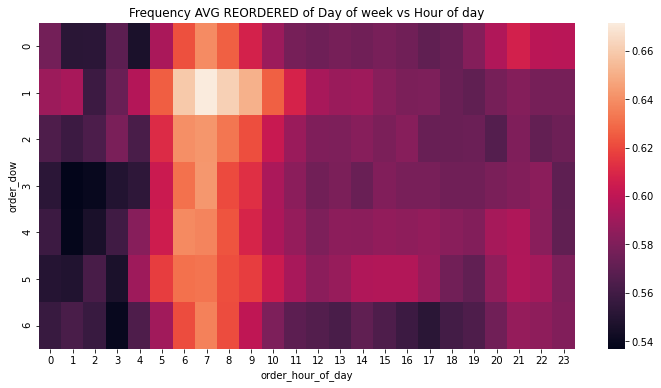

In [60]:
# merge customer past orders (order_prod_prior) & order in-depth details (orders)
orderprodprior_orders = pd.merge(order_prod_prior, orders, on='order_id', how='left')

# group data by order_dow, order_hour_of_day, and get average of reordered
grouped_df = orderprodprior_orders.groupby(['order_dow', 'order_hour_of_day'])['reordered'].aggregate('mean').reset_index()
grouped_df.head(3)
display(grouped_df)
grouped= grouped_df
# turn it to heatmap-suited format, by pivot it
grouped_df = grouped_df.pivot('order_dow', 'order_hour_of_day', 'reordered')
grouped_df.head(3)

# display result in heatmap 
plt.figure(figsize=(12,6))
sns.heatmap(grouped_df)
plt.title("Frequency AVG REORDERED of Day of week vs Hour of day")
plt.show()


# highest on Sunday between 6am to 9am (nice)
# in general, for any days, highest between 5am to 9am
# interpretation : 0.66 means, 66% of all orders are actually reorders (returning customers)

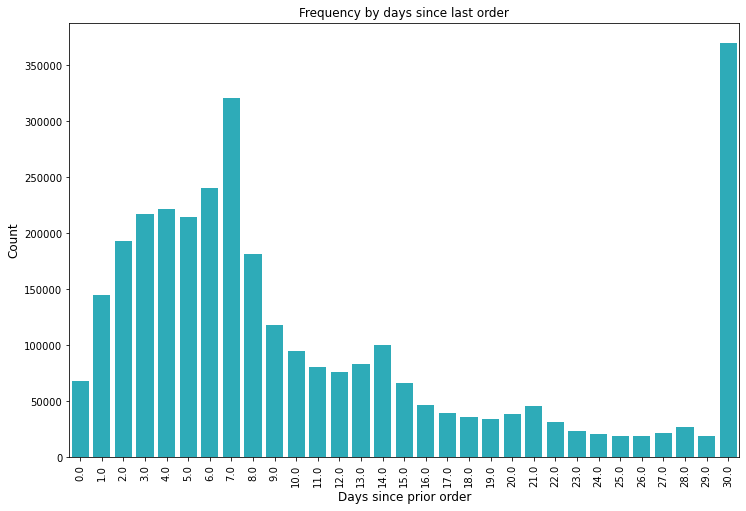

In [61]:
# Days since prior order column given
plt.figure(figsize=(12,8))
sns.countplot(x='days_since_prior_order', data=orders, color=color[9])
plt.ylabel('Count', fontsize=12)
plt.xlabel('Days since prior order', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency by days since last order")
plt.show()

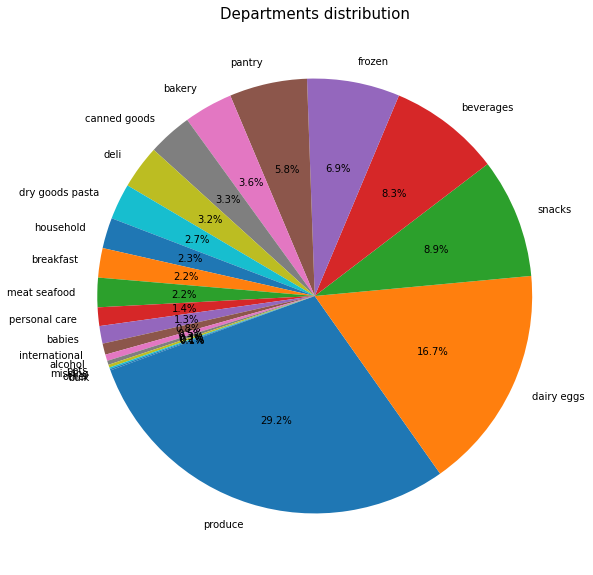

produce            0.292260
dairy eggs         0.166922
snacks             0.089027
beverages          0.082940
frozen             0.068952
pantry             0.057827
bakery             0.036282
canned goods       0.032930
deli               0.032411
dry goods pasta    0.026719
household          0.022774
breakfast          0.021877
meat seafood       0.021857
personal care      0.013785
babies             0.013066
international      0.008301
alcohol            0.004739
pets               0.003013
missing            0.002132
other              0.001119
bulk               0.001066
Name: department, dtype: float64

In [62]:
# department에 따른 비율
plt.figure(figsize=(10,10))
temp_series = all_join['department'].value_counts()
labels = (np.array(temp_series.index))
sizes = (np.array((temp_series / temp_series.sum())*100))
plt.pie(sizes, labels=labels, 
        autopct='%1.1f%%', startangle=200)
plt.title("Departments distribution", fontsize=15)
plt.show()
temp_series['Percentage']= temp_series/sum(temp_series)
temp_series['Percentage']

## Analysis

### Manipulate Train, Test data

In [63]:
# new df
new_df = data_1.copy()

In [64]:
new_df.isnull().sum()

user_id                                  0
product_id                               0
Times_Bought_N                           0
total_orders                             0
uxp_reorder_ratio                        0
u_reordered                              0
product_total_purchases                  0
p_reorder_ratio                          0
eval_set                                 0
order_id                                 0
order_hour_of_day                        0
order_dow                                0
days_since_prior_order                   0
department_id                            0
aisle_id                                 0
mean_position                            0
dept_reorder_rate                        0
aisle_reorder_rate                       0
dow_rordered                             0
dow_aisle_rordered                       0
dow_dept_rordered                        0
dept_percentage                          0
dow_hour_reorder                         0
product_reo

In [79]:
# Get train data and test data
train_data = new_df[new_df.eval_set=='train']
test_data = new_df[new_df.eval_set=='test']
# Get from order_prod_train all the products that the train users bought bought in their future order
train_data = train_data.merge(order_prod_train[['product_id','order_id', 'reordered']], on=['product_id','order_id'], how='left' )
train_data

,user_id,product_id,Times_Bought_N,total_orders,uxp_reorder_ratio,u_reordered,product_total_purchases,p_reorder_ratio,eval_set,order_id,...,prod_reordered_dpo,uxp_mean_position_x,day_reorder_rate,hour_reorder_rate,p_days_since_prior_order_reorder_rate,days_since_prior_reorder_rate,p_reduced_feat_1,p_reduced_feat_2,p_reduced_feat_3,reordered
0,1,196,10,10,1.000000,0.694915,35791,0.776480,train,1187899,...,0.010952,1.4,0.152580,0.078930,0.010952,0.1,1.0,0.0,0.0,1.0
1,1,196,10,10,1.000000,0.694915,35791,0.776480,train,1187899,...,0.017854,1.4,0.153642,0.085217,0.017854,0.1,1.0,0.0,0.0,1.0
2,1,196,10,10,1.000000,0.694915,35791,0.776480,train,1187899,...,0.014194,1.4,0.214272,0.113157,0.014194,0.1,1.0,0.0,0.0,1.0
3,1,196,10,10,1.000000,0.694915,35791,0.776480,train,1187899,...,0.007320,1.4,0.152580,0.019195,0.007320,0.1,1.0,0.0,0.0,1.0
4,1,196,10,10,1.000000,0.694915,35791,0.776480,train,1187899,...,0.027744,1.4,0.214272,0.068146,0.027744,0.1,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20641986,206209,44325,1,13,0.142857,0.472868,3485,0.401148,train,272231,...,0.041320,8.0,0.137733,0.071736,0.041320,1.0,0.0,0.0,0.0,NaN
20641987,206209,48370,1,13,0.333333,0.472868,3934,0.699288,train,272231,...,0.094814,8.0,0.123030,0.091510,0.094814,1.0,0.0,0.0,0.0,NaN
20641988,206209,48697,1,13,0.142857,0.472868,9783,0.357661,train,272231,...,0.032301,6.0,0.124502,0.083410,0.032301,1.0,0.0,0.0,0.0,NaN
20641989,206209,48742,2,13,0.285714,0.472868,1723,0.498549,train,272231,...,0.034823,9.0,0.123041,0.075450,0.034823,0.5,0.0,0.0,0.0,NaN


## Group by 'user_id', 'product_id'
- All number of orders with counting each products: 3.2million -> groupby user_id and product reduce to -> 1.3 million
1. Without this grouping prediciton model will predict same products over and over.
    | user_id | product_id | x1~xn|
    |---------|------------|------|
    | 1 | 196 | n1 |
    | 1 | 196 | n2 |
    | 1 | 196 | n3 |
    | 1 | 196 | n4... |
2. Variables that will change are only categorical data. <br/>
We can still use numerical data because these are the means of the grouped data

In [80]:
# 이렇게 user_id와 product_id로 groupby 해야 중복 데이터를 없앨수 있다.
train_data = train_data.groupby(['user_id', 'product_id']).mean()
test_data = test_data.groupby(['user_id', 'product_id']).mean()

In [81]:
#Where the previous merge, left a NaN value on reordered column means that the customers they haven't bought the product. We change the value on them to 0.
train_data['reordered'] = train_data['reordered'].fillna(0)
# drop the unused order_id
train_data = train_data.drop('order_id', axis = 1)
test_data = test_data.drop('order_id', axis = 1)

train_data.head(15)

Times_Bought_N  total_orders  uxp_reorder_ratio  \
user_id product_id                                                    
1       196                   10.0          10.0           1.000000   
        10258                  9.0          10.0           1.000000   
        10326                  1.0          10.0           0.166667   
        12427                 10.0          10.0           1.000000   
        13032                  3.0          10.0           0.333333   
        13176                  2.0          10.0           0.222222   
        14084                  1.0          10.0           0.100000   
        17122                  1.0          10.0           0.166667   
        25133                  8.0          10.0           1.000000   
        26088                  2.0          10.0           0.200000   
        26405                  2.0          10.0           0.200000   
        30450                  1.0          10.0           0.125000   
        35951                  1.0          10.0           1.000000   
        38928                  1.0          10.0           1.000000   
        39657                  1.0          10.0           1.000000   

                    u_reordered  product_total_purchases  p_reorder_ratio  \
user_id product_id                                                          
1       196            0.694915                  35791.0         0.776480   
        10258          0.694915                   1946.0         0.713772   
        10326          0.694915                   5526.0         0.652009   
        12427          0.694915                   6476.0         0.740735   
        13032          0.694915                   3751.0         0.657158   
        13176          0.694915                 379450.0         0.832555   
        14084          0.694915                  15935.0         0.810982   
        17122          0.694915                  13880.0         0.675576   
        25133          0.694915                   6196.0         0.740155   
        26088          0.694915                   2523.0         0.539041   
        26405          0.694915                   1214.0         0.441516   
        30450          0.694915                  21490.0         0.566682   
        35951          0.694915                  57895.0         0.757837   
        38928          0.694915                  13238.0         0.827769   
        39657          0.694915                   5019.0         0.766288   

                    order_hour_of_day  order_dow  days_since_prior_order  \
user_id product_id                                                         
1       196                 10.300000   2.500000               17.600000   
        10258               10.555556   2.555556               19.555556   
        10326               15.000000   4.000000               28.000000   
        12427               10.300000   2.500000               17.600000   
        13032                8.000000   2.666667               21.666667   
        13176               11.000000   3.500000               21.500000   
        14084                8.000000   2.000000                0.000000   
        17122               15.000000   4.000000               28.000000   
        25133               11.000000   2.500000               20.125000   
        26088                7.500000   2.500000                7.500000   
        26405                7.500000   3.000000               14.500000   
        30450               12.000000   3.000000               21.000000   
        35951                8.000000   4.000000               30.000000   
        38928                8.000000   4.000000               30.000000   
        39657                8.000000   4.000000               30.000000   

                    department_id  ...  prod_reordered_dpo  \
user_id product_id                 ...                       
1       196                   7.0  ...            0.025839   
        10258          

## Check Top features (corr>10%)

Index(['Times_Bought_N', 'uxp_reorder_ratio', 'product_total_purchases',
       'p_reorder_ratio', 'mean_position', 'dept_reorder_rate',
       'aisle_reorder_rate', 'dow_aisle_rordered', 'dow_dept_rordered',
       'product_reordered_dow', 'prod_reordered_hod',
       'days_since_prior_reorder_rate', 'reordered'],
      dtype='object')


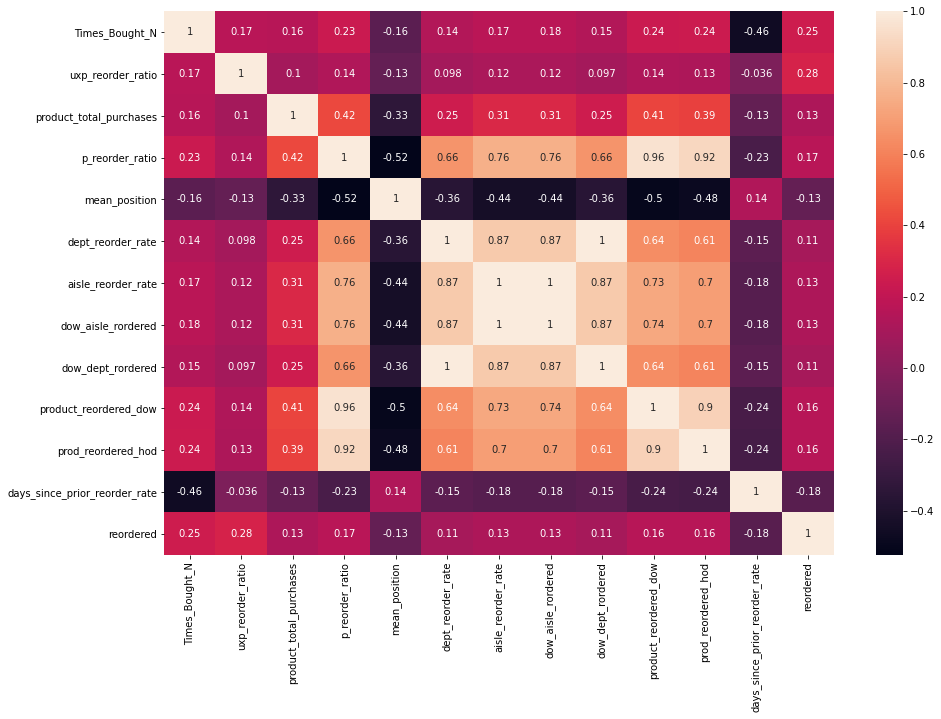

,Feature 1,Feature 2,Correlation Coefficient
34,reordered,reordered,1.000000
150,reordered,uxp_reorder_ratio,0.281601
160,reordered,Times_Bought_N,0.248376
197,reordered,days_since_prior_reorder_rate,0.177737
207,reordered,p_reorder_ratio,0.167360
212,reordered,product_reordered_dow,0.164952
219,reordered,prod_reordered_hod,0.162503
257,reordered,aisle_reorder_rate,0.130652
260,reordered,dow_aisle_rordered,0.130531
268,reordered,mean_position,0.129354


In [68]:
# 상관계수가 10% 이상인 종목만
cor = train_data.corr()
top_feature = cor.index[abs(cor['reordered']) >= 0.1]
print(top_feature)
top_corr = train_data[top_feature].corr()
plt.figure(figsize=(15,10))
sns.heatmap(top_corr, annot=True)
plt.xticks(rotation=90)
plt.show()

# corelation 확인
df_all_corr = train_data.corr().abs().unstack().sort_values(kind="quicksort", ascending=False).reset_index()
df_all_corr.rename(columns={"level_0": "Feature 1", "level_1": "Feature 2", 0: 'Correlation Coefficient'}, inplace=True)
df_all_corr[df_all_corr['Feature 1'] == 'reordered']

In [69]:
top_df=train_data[top_feature]
top_df

Times_Bought_N  uxp_reorder_ratio  \
user_id product_id                                      
1       196                   10.0           1.000000   
        10258                  9.0           1.000000   
        10326                  1.0           0.166667   
        12427                 10.0           1.000000   
        13032                  3.0           0.333333   
...                            ...                ...   
206209  43961                  3.0           0.300000   
        44325                  1.0           0.142857   
        48370                  1.0           0.333333   
        48697                  1.0           0.142857   
        48742                  2.0           0.285714   

                    product_total_purchases  p_reorder_ratio  mean_position  \
user_id product_id                                                            
1       196                         35791.0         0.776480       3.721774   
        10258                        1946.0         0.713772       4.277492   
        10326                        5526.0         0.652009       4.191097   
        12427                        6476.0         0.740735       4.760037   
        13032                        3751.0         0.657158       5.622767   
...                                     ...              ...            ...   
206209  43961                       55371.0         0.630583       9.194723   
        44325                        3485.0         0.401148      10.109900   
        48370                        3934.0         0.699288       8.344942   
        48697                        9783.0         0.357661       8.763058   
        48742                        1723.0         0.498549       7.991294   

                    dept_reorder_rate  aisle_reorder_rate  dow_aisle_rordered  \
user_id product_id                                                              
1       196                  0.653460            0.638832            0.651159   
        10258                0.574180            0.519170            0.531387   
        10326                0.649913            0.718104            0.720980   
        12427                0.574180            0.591986            0.598729   
        13032                0.560922            0.571584            0.572207   
...                               ...                 ...                 ...   
206209  43961                0.649913            0.638514            0.638814   
        44325                0.461076            0.453062            0.446837   
        48370                0.402178            0.528005            0.539190   
        48697                0.346721            0.350843            0.357642   
        48742                0.560922            0.499501            0.503363   

                    dow_dept_rordered  product_reordered_dow  \
user_id product_id                                             
1       196                  0.659752               0.789892   
        10258                0.578379               0.732247   
        10326                0.656404               0.626277   
        12427                0.578165               0.758102   
        13032                0.562591               0.686708   
...                               ...                    ...   
206209  43961                0.653955               0.635898   
        44325                0.454189               0.422917   
        48370                0.407662               0.692149   
        48697                0.350453               0.354680   
        48742                0.567525               0.481132   

                    prod_reordered_hod  days_since_prior_reorder_rate  \
user_id product_id                                                      
1       196                   0.784557                       0.100000   
        10258                 0.737162                       0.111111   
        10326                 0.684343                       1.000000  

## Divide Train & Validation dataset
- 80% for Training
- 20% for Validation

In [75]:
# TRAIN FULL 

###########################
## IMPORT REQUIRED PACKAGES
###########################
import xgboost
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
# train_data.loc[:, 'reordered'] = train_data.reordered.fillna(0)

########################################
## SPLIT DF TO: X_train, y_train (axis=1)
########################################
X_train, X_val, y_train, y_val = train_test_split(train_data.drop('reordered', axis=1), train_data.reordered,
                                                    test_size=0.2, random_state=42)

###  XGB Max depth manipulation
- max_depth 8 had the best outcome

In [ ]:
# # depth check
# depth_list = [4,5,6,7,8]
# n_estimators_list = [100,200,300]
# learning_rate_list= []
# d_train = xgboost.DMatrix(X_train, y_train)

# watchlist= [(d_train, "train")]
# model_list = []
# for dl in depth_list:
#     xgb_params = {
#     "objective"         : "reg:logistic"
#     ,"eval_metric"      : "logloss"
#     ,"eta"              : 0.1
#     ,"max_depth"        : dl
#     ,"min_child_weight" :10
#     ,"gamma"            :0.70
#     ,"subsample"        :0.76
#     ,"colsample_bytree" :0.95
#     ,"alpha"            :2e-05
#     ,"lambda"           :10
#     }
#     xgb = xgb_params
#     xgb_t =xgboost.train(params=xgb, dtrain=d_train, num_boost_round=80, evals=watchlist, verbose_eval=10)
#     model_list.append(xgb_t)
#     xgboost.plot_importance(xgb_t)
# check_acc=[]
# check_precision=[]
# check_f1=[]

# for idx, i in enumerate(model_list):
#     pred_result=(i.predict(val_pred)> 0.5).astype(int)
#     print(idx)
#     check_acc.append([idx,format(accuracy_score(y_val, pred_result))])
#     check_precision.append([idx,format(precision_score(y_val, pred_result))])
#     check_f1.append([idx, format(f1_score(y_val, pred_result))])

#     print('XGBoost model accuracy score: {0:0.4f}'. format(accuracy_score(y_val, pred_result)))
#     print('XGBoost model precision_score score: {0:0.4f}'. format(precision_score(y_val, pred_result)))
#     print('XGBoost model f1 score: {0:0.4f}'. format(f1_score(y_val, pred_result)))

### Xgboost GridSearchCV
#### Problems
- Memory problem (How do I solve it?)

In [ ]:
# # Gridsearchcv
# from sklearn.model_selection import StratifiedKFold
# greed_model = xgboost.XGBClassifier(objective='binary:logistic', eval_metric='logloss', num_boost_round=10)


# param_random = {"max_depth" : [6,8],
#             "colsample_bytree" : [0.3, 0.4],
#             "learning_rate" : [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]}

# # kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
# grid_search = GridSearchCV(greed_model, param_grid, scoring="neg_log_loss", n_jobs=-1, cv=kfold) # cv 제외후 돌리기
# grid_result = grid_search.fit(X_train, y_train)
# # summarize results
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
# 	print("%f (%f) with: %r" % (mean, stdev, param))
# # plot
# pyplot.errorbar(learning_rate, means, yerr=stds)
# pyplot.title("XGBoost learning_rate vs Log Loss")
# pyplot.xlabel('learning_rate')
# pyplot.ylabel('Log Loss')
# pyplot.savefig('learning_rate.png')

## Xgboost

In [262]:
import xgboost as xgb
from datetime import datetime
def train_xgb(X_train, X_test, y_train, y_test, plot_importance = True, save = True, file_name = None, params = None):
    
    """
    Returns trained XGB model and output probabilities of validation set
    
    Parameters
    ----------
    X_train              : X_train data is passed 
    X_test               : X_test data is passed
    y_train              : y_train data is passed
    y_test               : y_test data is passed
    plot_importance      : The default is True
                          Boolean variable , Set to True if feature Importance
                          needs to be plotted
    save                 : The default is True
                          Boolean variable , Set to True if trained model 
                          needs to be saved
    file_name            : The default is None
                          Filename to be used while saving model
    params               : The default is None
                          dict of parameter set used to train XGBoost model
    Returns
    -------
    xgb_model            :  Trained XGBoost Model
    predict_y            : output probabilities for validation data
    """

    #defining set of parameters, these are optimal parameters obatined after 
    # rigorous hyperparameter Tuning
    if params is None:
        params = {}
        params['objective'] = 'binary:logistic'
        params['eval_metric'] = ['logloss']
        params['eta'] = 0.02
        params['max_depth'] = 15
        params['nthread']=-1
        params['colsample_bytree'] = 0.4
        params['tree_method'] = 'gpu_hist'
        
    #Create DataMatrix for XGBoost
    d_train = xgb.DMatrix(X_train, label=y_train)
    d_test = xgb.DMatrix(X_val, label=y_val)

    watchlist = [(d_train, 'train'), (d_test, 'valid')]
    
    #output Training Time
    start_time = datetime.now()
    print("Training Started :")
    xgb_model = xgb.train(params, d_train, 300, watchlist, early_stopping_rounds=20, verbose_eval=10)
    print("Training Completed ")
    end_time = datetime.now()
    difference = end_time - start_time
    time = divmod(difference.total_seconds() , 360)
    print("Total Time : {} minutes {} seconds".format(time[0], time[1]))
    
    #get probabilities for validation set
    predict_y = xgb_model.predict(d_test)
    print("The test log loss is:",log_loss(y_val, predict_y, labels=[0,1], eps=1e-15))
    
    #save trained model
    try:
        if save:
            file_name = "xgb_v1.pkl"

            # save
            pickle.dump(bst, open(file_name, "wb"))
    except Exception:
        pass
    #plot Feature Importance
    if plot_importance:
        print("Feature Importance")
        fig, ax = plt.subplots(1,1,figsize=(10,10))
        xgb.plot_importance(booster = bst, ax = ax)

    return xgb_model, predict_y

Training Started :
[0]	train-logloss:0.67961	valid-logloss:0.67971
[10]	train-logloss:0.56472	valid-logloss:0.56619
[20]	train-logloss:0.48512	valid-logloss:0.48778
[30]	train-logloss:0.42594	valid-logloss:0.42994
[40]	train-logloss:0.38280	valid-logloss:0.38803
[50]	train-logloss:0.34980	valid-logloss:0.35629
[60]	train-logloss:0.32462	valid-logloss:0.33236
[70]	train-logloss:0.30496	valid-logloss:0.31413
[80]	train-logloss:0.28948	valid-logloss:0.30011
[90]	train-logloss:0.27711	valid-logloss:0.28911
[100]	train-logloss:0.26734	valid-logloss:0.28070
[110]	train-logloss:0.25983	valid-logloss:0.27457
[120]	train-logloss:0.25366	valid-logloss:0.26968
[130]	train-logloss:0.24837	valid-logloss:0.26588
[140]	train-logloss:0.24387	valid-logloss:0.26281
[150]	train-logloss:0.24029	valid-logloss:0.26055
[160]	train-logloss:0.23680	valid-logloss:0.25853
[170]	train-logloss:0.23433	valid-logloss:0.25732
[180]	train-logloss:0.23197	valid-logloss:0.25627
[190]	train-logloss:0.22962	valid-logloss:

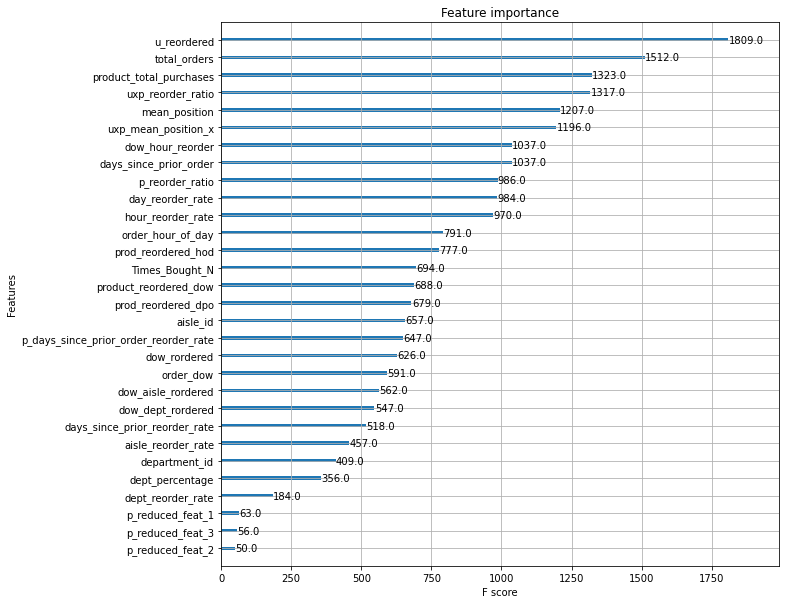

In [333]:
xgb_model = train_xgb(X_train, X_val, y_train, y_val)

## LogisticRegression

In [ ]:
# LogisticRegression
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(random_state=42, n_jobs = -1)
log_reg.fit(X_train, y_train)

predict_lgr = log_reg.predict_proba(X_val)
print("logloss on validation data :",log_loss(y_val, predict_lgr, labels=[0,1], eps=1e-15))

In [ ]:
y_test_pred_lgr = (log_reg.predict(X_val)>0.1).astype(int)

In [ ]:
print('LogisticRegression model accuracy score: {0:0.4f}'. format(accuracy_score(y_val, y_test_pred_lgr)))
print('LogisticRegression model precision_score score: {0:0.4f}'. format(precision_score(y_val, y_test_pred_lgr)))
print('LogisticRegression model F1:',f1_score(y_val, y_test_pred_lgr))

## DecisionTreeClassifier

In [303]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV

param_grid = {}
param_grid['max_depth'] = [5,10,15,20]
param_grid['min_samples_split'] = [2,3,4,5]

dt_clf = DecisionTreeClassifier()
r_search = RandomizedSearchCV(dt_clf, param_distributions=param_grid, cv = 5, verbose = True, n_jobs = -1)
r_search.fit(X_train, y_train)

predict_y = r_search.predict_proba(X_val)


Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [191]:
print("logloss on validation data :",log_loss(y_val, predict_y, labels=[0,1], eps=1e-15))
print('최적 하이퍼파라미터: ', r_search.best_params_)
y_test_pred = r_search.predict(X_val)
print('검증 정확도:', r_search.best_score_)
print('F1:',f1_score(y_val, y_test_pred, pos_label = 1))

logloss on validation data : 0.2551356465405522
최적 하이퍼파라미터:  {'min_samples_split': 5, 'max_depth': 10}
검증 정확도: 0.9075813956009338
F1: 0.24071188704261065


## Catboost

In [280]:
from catboost import CatBoostClassifier

def train_catboost(X_train, X_test, y_train, y_test, plot_importance = True, save = True, file_name = None):
    
    """
    Returns trained catboost model and output probabilities of validation set
    
    Parameters
    ----------
    X_train              : X_train data is passed 
    X_test               : X_test data is passed
    y_train              : y_train data is passed
    y_test               : y_test data is passed
    plot_importance      : The default is True
                          Boolean variable , Set to True if feature Importance
                          needs to be plotted
    save                 : The default is True
                          Boolean variable , Set to True if trained model 
                          needs to be saved
    file_name            : The default is None
                          Filename to be used while saving model
    Returns
    -------
    xgb_model            :  Trained XGBoost Model
    predict_y            : output probabilities for validation data
    """


    start_time = datetime.now()
    print("Training Started :")

    #defining set of parameters, these are optimal parameters obatined after 
    # rigorous hyperparameter Tuning
    c_model = CatBoostClassifier(task_type = "GPU", verbose=False, depth = 13, iterations= 2000, learning_rate= 0.02, scale_pos_weight= 1.0)
    c_model.fit(X_train,y_train)
    print("Training Completed ")
    end_time = datetime.now()
    difference = end_time - start_time
    time = divmod(difference.total_seconds() , 3600)
#     print("Total Time : {} hours {} seconds".format(time[0], time[1]))
    
    #get output probabilities
    predict_y = c_model.predict_proba(X_test)
    print("The Test log loss is:",log_loss(y_test, predict_y, labels=[0,1], eps=1e-15))
    
    #get probs for class 1
    predict_y = predict_y[:,-1]
    
    #save the model    
    try:
        if save:
            file_name = "cat_v1.pkl"

            # save
            pickle.dump(c_model, open(file_name, "wb"))
    except Exception:
        pass
    
    #plot feature importance
    if plot_importance:
        #ref: https://stackoverflow.com/a/65842279/11533069
        f_imp=pd.DataFrame({'features': X_train.columns.to_numpy(),'feature_importance': c_model.get_feature_importance()})
        f_imp.sort_values(by = 'feature_importance', ascending = False, inplace = True)

        print("Feature Importance")
        fig, ax = plt.subplots(1,1,figsize=(10,10))
        sns.barplot(x = f_imp['feature_importance'], y = f_imp['features'])
        plt.title('Feature Importance')
        plt.xlabel('Importance')
        plt.ylabel('Features')

    return c_model, predict_y

Training Started :
Training Completed 
The Test log loss is: 0.2517128879482444
Feature Importance


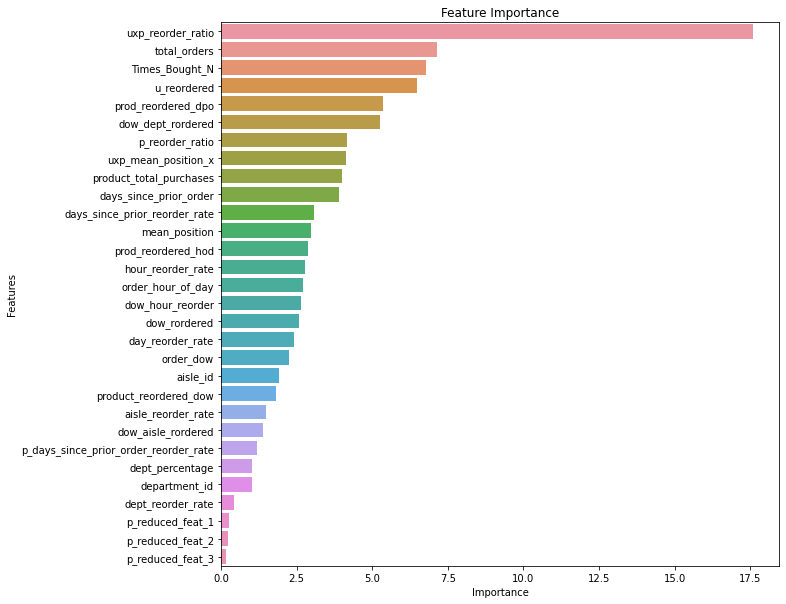

In [307]:
catboost_model = train_catboost(X_train, X_val, y_train, y_val)

## Validation & Result

In [433]:
# a모델 생성 코드
def test_result(model_name, model, test_x, val_x, val_y):
    prediction = test_x.reset_index()
    prediction = prediction[['product_id', 'user_id']]
    
    result = 0.
    if model_name =='Xgboost':
        d_test = xgb.DMatrix(test_x)
        result = model.predict(d_test)
        prediction["reordered"] = (model.predict(d_test)> 0.2).astype(int)
    else:
        result = model.predict(test_x)
        prediction["reordered"] = (model.predict(test_x)> 0.2).astype(int)

    orders_val = orders[orders.eval_set=='test']
    prediction = prediction.merge(orders_val[["user_id", "order_id"]], on='user_id', how='left')

    prediction['product_id'] = prediction.product_id.astype(int)
    prediction = prediction.drop('user_id', axis=1)
    gc.collect()
    
    # validation
    if model_name =='Xgboost':
        d_val= xgb.DMatrix(val_x)
        val_prediction = (model.predict(d_val)> 0.2).astype(int)
    else:
        val_prediction = (model.predict(val_x)> 0.2).astype(int)

    print(model_name + ' model validation accuracy score: {0:0.4f}'. format(accuracy_score(val_y, val_prediction)))
    print(model_name + ' model validation precision_score score: {0:0.4f}'. format(precision_score(val_y, val_prediction)))
    print(model_name + ' model validation f1 score: {0:0.4f}'. format(f1_score(val_y, val_prediction)))
    
    d_val = dict()
    for row in prediction.itertuples():
        if row.reordered == 1:
            try:
                d_val[row.order_id] += ' ' + str(row.product_id)
            except:
                d_val[row.order_id] = str(row.product_id)

    for order in prediction.order_id:
        if order not in d_val:
            d_val[order] = 'None'
    #Convert the dictionary into a DataFrame
    sub_val = pd.DataFrame.from_dict(d_val, orient='index')

    #Reset index
    sub_val.reset_index(inplace=True)
    #Set column names
    sub_val.columns = ['order_id', 'products']
    gc.collect()
    sub_val.to_csv('submission_'+ model_name +'.csv', index=False)
    return prediction["reordered"]

### Xgboost Result

In [437]:
# Xgboost result
xgb_result = test_result('Xgboost', xgb_model[0], test_data, X_val, y_val)
xgb_result

Xgboost model validation accuracy score: 0.8666
Xgboost model validation precision_score score: 0.3663
Xgboost model validation f1 score: 0.4208


0          0
1          0
2          0
3          0
4          0
          ..
4833287    0
4833288    0
4833289    0
4833290    0
4833291    0
Name: reordered, Length: 4833292, dtype: int64

### Logistic Regression

In [434]:
log_reg_result = test_result('Logistic Regression', log_reg, test_data, X_val, y_val)
log_reg_result

Logistic Regression model validation accuracy score: 0.9033
Logistic Regression model validation precision_score score: 0.5817
Logistic Regression model validation f1 score: 0.0876


0          0
1          0
2          0
3          0
4          0
          ..
4833287    0
4833288    0
4833289    0
4833290    0
4833291    0
Name: reordered, Length: 4833292, dtype: int64

### Catboost Result

In [435]:
# Catbost result
catboost_result = test_result('catboost', catboost_model[0], test_data, X_val, y_val)
catboost_result

catboost model validation accuracy score: 0.9081
catboost model validation precision_score score: 0.6300
catboost model validation f1 score: 0.2433


0          0
1          0
2          0
3          0
4          0
          ..
4833287    0
4833288    0
4833289    0
4833290    0
4833291    0
Name: reordered, Length: 4833292, dtype: int64

### Random Forest Result

In [436]:
# Random Forest result
rf_result = test_result('random forest', r_search, test_data, X_val, y_val)
rf_result

random forest model validation accuracy score: 0.9074
random forest model validation precision_score score: 0.6141
random forest model validation f1 score: 0.2407


0          0
1          0
2          0
3          0
4          0
          ..
4833287    0
4833288    0
4833289    0
4833290    0
4833291    0
Name: reordered, Length: 4833292, dtype: int64

### Ensamble all the result
- When I tried the ensemble the result improved 
<br>
Score: 0.363 -> 0.36379
<br>
Public Score: 0.36455 -> 0.36571

In [432]:
prediction = test_data.reset_index()
prediction = prediction[['product_id', 'user_id']]
orders_val = orders[orders.eval_set=='test']
prediction = prediction.merge(orders_val[["user_id", "order_id"]], on='user_id', how='left')

prediction['product_id'] = prediction.product_id.astype(int)
prediction = prediction.drop('user_id', axis=1)
gc.collect()
ensemble_result = (rf_result + xgb_result + catboost_result + log_reg_result)/4
print(ensemble_result.sum())
prediction['reordered'] = (ensemble_result> 0.).astype(int)
d_val = dict()
for row in prediction.itertuples():
    if row.reordered == 1:
        try:
            d_val[row.order_id] += ' ' + str(row.product_id)
        except:
            d_val[row.order_id] = str(row.product_id)

for order in prediction.order_id:
    if order not in d_val:
        d_val[order] = 'None'
#Convert the dictionary into a DataFrame
sub_val = pd.DataFrame.from_dict(d_val, orient='index')

#Reset index
sub_val.reset_index(inplace=True)
#Set column names
sub_val.columns = ['order_id', 'products']
gc.collect()
sub_val.to_csv('submission_ensemble.csv', index=False)
sub_val.head()

227879.75


,order_id,products
0,2774568,9387 17668 18599 21903 39190 43961 47766
1,1528013,21903 38293
2,1376945,8309 13176 14947 24799 27959 28465 33572 34658...
3,1356845,7076 10863 11520 13176 14992
4,2161313,196 10441 11266 12427 14715 27839 37710
